<a href="https://colab.research.google.com/github/manoranjan11/kaggle/blob/master/Real%20or%20Not%3F%20NLP%20with%20disaster%20tweets/Twitter_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install required versions of libraries 
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet seaborn
!pip3 install pyspellchecker

In [2]:
#importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import defaultdict
import nltk
from nltk.corpus import stopwords

from nltk.util import ngrams
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

import re
from spellchecker import SpellChecker

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
import itertools
import datetime
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Lambda, SpatialDropout1D, Dense
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers


from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from keras.optimizers import Adadelta

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [3]:
#link to github repository
!rm -r kaggle
!git clone https://github.com/manoranjan11/kaggle.git

Cloning into 'kaggle'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 51 (delta 22), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (51/51), done.


In [0]:
# Importing the dataset
train_dataset = pd.read_csv('/content/kaggle/Real or Not? NLP with disaster tweets/train(1).csv')
test_dataset = pd.read_csv('/content/kaggle/Real or Not? NLP with disaster tweets/test(1).csv')

In [5]:
train_dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Text(0, 0.5, 'samples')

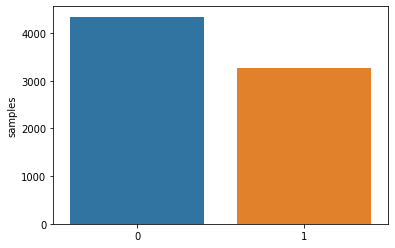

In [6]:
#class distribution
x=train_dataset.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

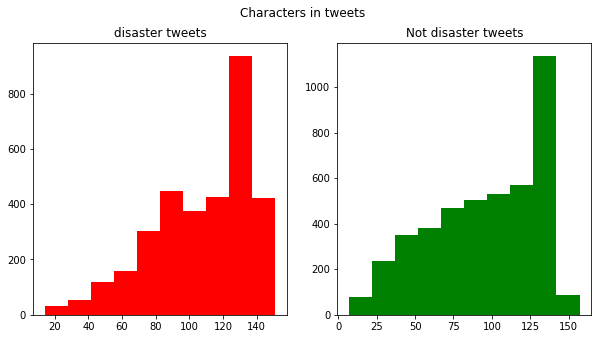

In [7]:
#character analysis
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_dataset[train_dataset['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train_dataset[train_dataset['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

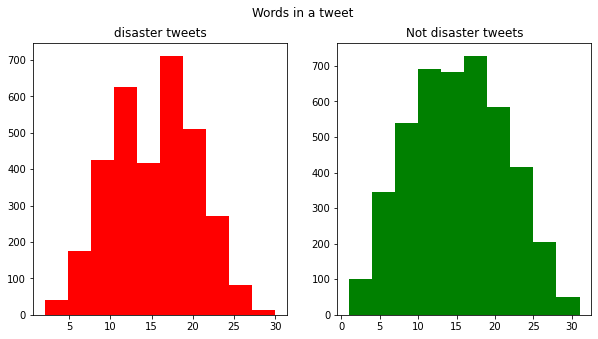

In [8]:
#word analysis
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_dataset[train_dataset['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train_dataset[train_dataset['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

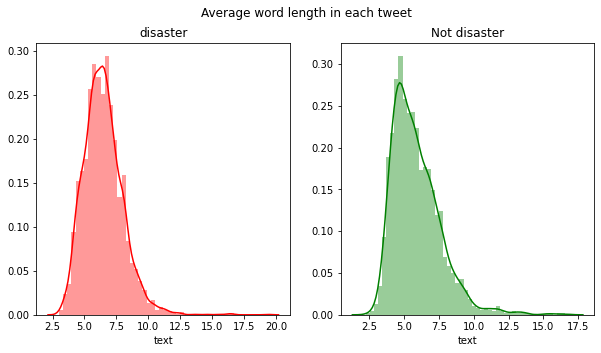

In [9]:
#Average word length
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train_dataset[train_dataset['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=train_dataset[train_dataset['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [0]:
#create corpus
def create_corpus(target):
    corpus=[]
    
    for x in train_dataset[train_dataset['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<BarContainer object of 10 artists>

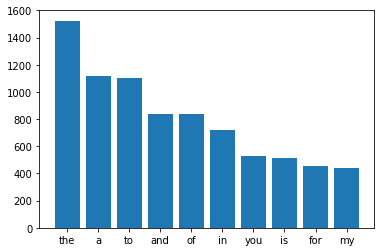

In [12]:
#analyze target=0
corpus=create_corpus(0)
stop=set(stopwords.words('english'))
dic=defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

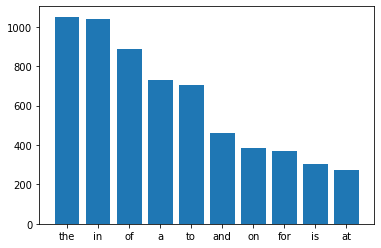

In [13]:
#analyze target=1
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 18 artists>

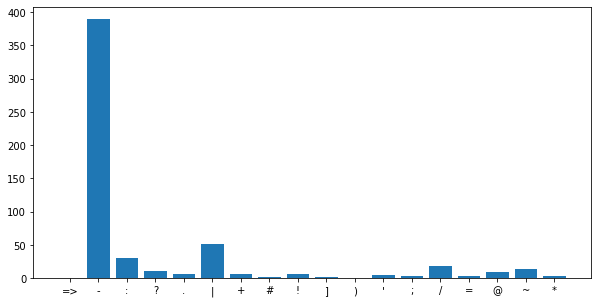

In [14]:
#analyze punctuations in target=1
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

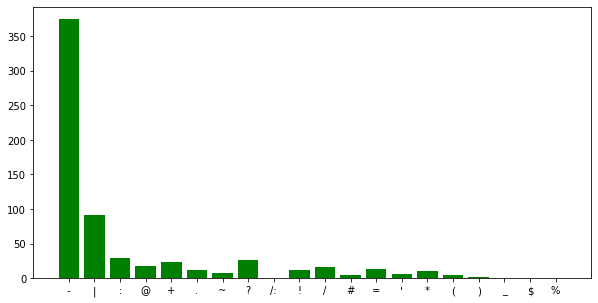

In [15]:
#analyze punctuations in target=0
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

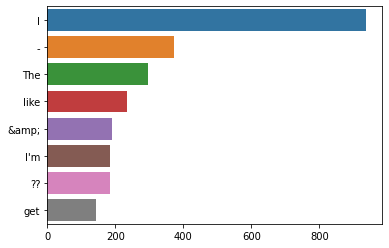

In [16]:
#Common Words
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

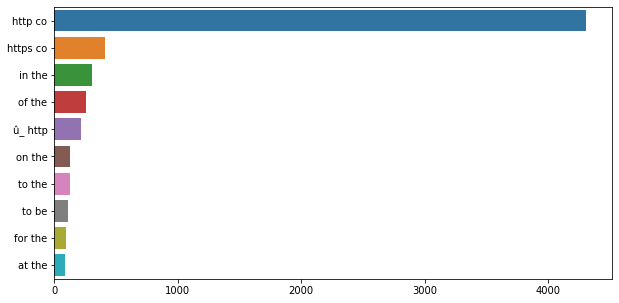

In [17]:
#ngram analysis
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(train_dataset['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [18]:
#Data Cleaning
#df=pd.concat([train_dataset,test_dataset])
#df.shape

example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

train_dataset['text']=train_dataset['text'].apply(lambda x : remove_URL(x))
test_dataset['text']=test_dataset['text'].apply(lambda x : remove_URL(x))

example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

print(remove_html(example))

train_dataset['text']=train_dataset['text'].apply(lambda x : remove_html(x))
test_dataset['text']=test_dataset['text'].apply(lambda x : remove_html(x))

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

train_dataset['text']=train_dataset['text'].apply(lambda x : remove_emoji(x))
test_dataset['text']=test_dataset['text'].apply(lambda x : remove_emoji(x))

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

train_dataset['text']=train_dataset['text'].apply(lambda x : remove_punct(x))
test_dataset['text']=test_dataset['text'].apply(lambda x : remove_punct(x))

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

#train_dataset['text']=train_dataset['text'].apply(lambda x : correct_spellings(x))
#test_dataset['text']=test_dataset['text'].apply(lambda x : correct_spellings(x))


Real or Fake
Kaggle 
getting started

I am a king


'correct me please'

In [19]:
train_dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1


In [20]:
#test google encoder in TF2
hub_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
embed = hub.load(hub_url)
embeddings = embed(["The quick brown fox jumps over the lazy dog."])

print(embeddings)

tf.Tensor(
[[ 1.30510554e-02  2.23512053e-02 -3.26327495e-02 -2.20062155e-02
  -1.97359193e-02  2.87827104e-03 -4.99825813e-02 -6.57383576e-02
  -1.06090613e-01 -8.26308690e-03 -5.18092373e-03 -4.60234098e-02
   1.01428311e-02  4.80910279e-02 -2.42416356e-02 -6.52229460e-03
  -2.58720554e-02 -2.92225946e-02 -7.66655570e-03 -1.58022251e-02
   1.49503518e-02  1.38627989e-02 -6.49455190e-02  2.68793758e-02
  -2.44950335e-02 -5.51504865e-02  3.06375381e-02  9.46218614e-03
   4.71525937e-02  1.67700592e-02 -2.67634336e-02  8.53415485e-03
   4.10483181e-02  5.43544777e-02  2.49953698e-02  8.80336538e-02
   7.30200717e-03  7.00786039e-02  3.80278230e-02 -4.04341556e-02
   2.31793970e-02  8.42554495e-02  1.05559798e-02 -1.95747837e-02
   1.17703946e-02  2.67261975e-02 -1.22729778e-01 -2.36627627e-02
  -5.76132797e-02 -2.08594818e-02 -5.39495051e-02 -8.13628361e-02
  -2.09483448e-02 -9.78392363e-02 -3.36710364e-02 -7.71650299e-02
  -1.99453812e-02 -5.14010957e-04 -7.94349611e-03  9.59451590e-03

In [0]:
X_train = train_dataset.iloc[:, 3].values
y_train = train_dataset.iloc[:, 4].values
X_test = test_dataset.iloc[:,3].values

In [0]:
#splitting into test & train
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [0]:
#encoding
X_train_embed = embed(X_train)
X_test_embed = embed(X_test)

In [0]:
X_train_embed = X_train_embed[:,np.newaxis,:]

In [0]:
X_test_embed = X_test_embed[:,np.newaxis,:]

In [83]:
X_test_embed.shape

TensorShape([3263, 1, 512])

In [0]:
#Building a model
model = Sequential()

In [67]:
model.add(Input(shape=(1,512),dtype='float32'))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_dropout1d_8 (Spatial (None, 1, 512)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 1, 256)            131328    
_________________________________________________________________
lstm_7 (LSTM)                (None, 1)                 1032      
Total params: 132,360
Trainable params: 132,360
Non-trainable params: 0
_________________________________________________________________


In [0]:
from time import time

In [84]:
training_start_time = time()

trained = model.fit(X_train_embed, y_train, batch_size=64, epochs=100,validation_split=0.2)

print("Training time finished.\n{} epochs in {}".format(100, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/100
96/96 [==============================] - 1s 8ms/step - loss: 0.4497 - accuracy: 0.8048 - val_loss: 0.4113 - val_accuracy: 0.8299
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.4499 - accuracy: 0.8079 - val_loss: 0.4105 - val_accuracy: 0.8293
Epoch 3/100
96/96 [==============================] - 1s 8ms/step - loss: 0.4502 - accuracy: 0.8067 - val_loss: 0.4098 - val_accuracy: 0.8293
Epoch 4/100
96/96 [==============================] - 1s 8ms/step - loss: 0.4476 - accuracy: 0.8064 - val_loss: 0.4090 - val_accuracy: 0.8299
Epoch 5/100
96/96 [==============================] - 1s 9ms/step - loss: 0.4500 - accuracy: 0.8089 - val_loss: 0.4083 - val_accuracy: 0.8299
Epoch 6/100
96/96 [==============================] - 1s 7ms/step - loss: 0.4498 - accuracy: 0.8069 - val_loss: 0.4077 - val_accuracy: 0.8299
Epoch 7/100
96/96 [==============================] - 1s 10ms/step - loss: 0.4481 - accuracy: 0.8046 - val_loss: 0.4071 - val_accuracy: 0.8299
Epoch 8/100

In [0]:
y_pred = model.predict(X_test_embed)

In [0]:
for i in range(0,len(y_pred)):
  if y_pred[i]>=0.5:
    y_pred[i] = 1
  else:
    y_pred[i] = 0

In [0]:
from sklearn.metrics import confusion_matrix as cm

In [77]:
cm(y_pred,y_test)

array([[698, 147],
       [188, 490]])

In [0]:
np.savetxt(fname="y_pred.csv", delimiter=",", X=y_pred)